In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


%matplotlib inline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

### Init lists for the analysis

HAPPY = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P'
    , ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

SAD = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
dt = ['not', 'no', 'for', 'and', 'nor', 'but', 'or', 'so',
        'while', 'if', 'only', 
        'until', 'than', 
         'as', 'after', 'before',
        'by', 'now', 'once',
        'when', 'because','in',
        'why', 'what', 'which', 'who', 
         'how', 'where','just', 'both', 
        'with', 'then']

conjunctions = ['for', 'and', 'nor', 'but', 'or', 'yet', 'so',
        'though', 'although', 'even though', 'while', 'if', 'only if', 'unless',
        'until', 'provided that', 'assuming that', 'even if', 'in case', 'than', 'rather than',
        'whether', 'as much as', 'whereas', 'after', 'as long as', 'as soon as', 'before',
        'by the time', 'now that', 'once', 'since', 'till', 'until',
        'when', 'whenever', 'while', 'because', 'since', 'so that', 'in order',
        'why', 'that', 'what', 'whatever', 'which', 'whichever', 'who', 'whoever',
        'whom', 'whomever', 'whose', 'how', 'as though', 'as if','where', 'wherever',
        'also', 'besides', 'furthermore', 'likewise', 'moreover', 'however', 'nevertheless',
        'nonetheless', 'still', 'conversely', 'instead', 'otherwise', 'rather', 'accordingly',
        'consequently', 'hence', 'meanwhile', 'then', 'therefore', 'thus']

NEGATE = {'ain\'t', 'aren\'t', 'cannot', 'can\'t', 'couldn\'t', 'daren\'t', 'didn\'t', 'doesn\'t',
 'ain\'t', 'aren\'t', 'cant', 'couldn\'t', 'daren\'t', 'didn\'t', 'doesn\'t',
 "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", 'neither',
 "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
 "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
 "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
 "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
 "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite",'!'}

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


NameError: name 'vader' is not defined

# Sentiment Model

In [4]:
def parse_dataset(fp):
    '''
    Loads the dataset file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"): # discard first line if it contains metadata
                line = line.rstrip() # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y



In [5]:
### Train Data

data, y_label = parse_dataset('SemEval2018-T3-train-taskA_emoji.txt')
data_df = pd.DataFrame(np.array(data).reshape(3834,1), columns = ['tweet'])
data_df['label'] = np.array(y_label).reshape(3834,1)
data_df.head()


,tweet,label
0,Sweet United Nations video. Just in time for C...,1
1,@mrdahl87 We are rumored to have talked to Erv...,1
2,Hey there! Nice to see you Minnesota/ND Winter...,1
3,3 episodes left I'm dying over here,0
4,"""I can't breathe!"" was chosen as the most nota...",1


In [6]:
### Test Data

# Test the model
test_data, test_label = parse_dataset('SemEval2018-T3_gold_test_taskA_emoji.txt')
test_df = pd.DataFrame(np.array(test_data).reshape(784,1), columns = ['tweet'])
test_df['label'] = np.array(test_label).reshape(784,1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
tweet    784 non-null object
label    784 non-null int64
dtypes: int64(1), object(1)
memory usage: 12.4+ KB


## Model Functions

In [7]:
from sklearn import svm 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [9]:
from sklearn.metrics import confusion_matrix

def plotCM(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

## Define the sentiment extraction function

In [10]:
def sentimentAnalysis(sentencePart, feature):

    
    sia = SentimentIntensityAnalyzer()
    tweet_len = len(sentencePart.split(' '))

    pos_word_list=[]
    neu_word_list=[]
    neg_word_list=[]
    highest_pos = float('-inf')
    lowest_neg = float('inf')
    emoji=[]
    negate_flag = False
    total_polarity = 0

#     threshold = -0.3 -> 0.3
    for word in sentencePart.split(' '):
        hashtag_flag = False

#         do some preprocessing
        if(word.startswith('#')):
            hashtag_flag = True
            word = word.replace('#', '')
        
        comp_polarity = sia.polarity_scores(word)['compound']
        if(hashtag_flag):
            comp_polarity = 1.2 * comp_polarity
        if(negate_flag):
            comp_polarity = -(comp_polarity)
        total_polarity += comp_polarity
        
#         if word = 'not' implies negate flag till punctuation
#         if (word in NEGATE):
#             negate_flag = True
            
#         if(word in string.punctuation):
#             negate_flag = False
            
        if (comp_polarity) >= 0.3 or word in HAPPY:
            if(comp_polarity > highest_pos):
                highest_pos = comp_polarity
            pos_word_list.append(word)
        
        elif (comp_polarity) <= -0.3 or word in NEGATE or word in SAD:
            if(comp_polarity < lowest_neg):
                lowest_neg = comp_polarity
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)
    
    if(feature == 'avg'):
        return [len(pos_word_list)/tweet_len, len(neu_word_list)/tweet_len, len(neg_word_list)/tweet_len]
    if(feature == 'overall'):
        return total_polarity/tweet_len
    if(feature == 'diff'):
        diff = highest_pos - lowest_neg
        if(diff == float('-inf') or diff == float('inf')):
            return 0
        else:
            return diff
        return highest_pos - lowest_neg
    if(feature == 'inversion'):
        return len(pos_word_list) and len(neg_word_list)
    

In [11]:
data_df['tweet'][3]
sentimentAnalysis('3 episodes left Im dying over here', feature = 'avg')

[0.0, 1.0, 0.0]

### Feature Extract

In [12]:
def syntactic_feature_extract(og_df):
    df = og_df.copy()
    df[['positive_avg','neutral_avg', 'negative_avg']] = df['tweet'].apply(lambda x: pd.Series(sentimentAnalysis(x, feature = 'avg')))
    df['overall'] = df['tweet'].apply(lambda x: sentimentAnalysis(x, feature = 'overall'))
    df['diff'] = df['tweet'].apply(lambda x: sentimentAnalysis(x, feature = 'diff'))
    df['inversion'] = df['tweet'].apply(lambda x: sentimentAnalysis(x, feature = 'inversion'))

    return df.drop(['tweet'], axis=1)

In [13]:
syntactic_df = syntactic_feature_extract(data_df)
syntactic_df

,label,positive_avg,neutral_avg,negative_avg,overall,diff,inversion
0,1,0.153846,0.846154,0.000000,0.067715,0.0000,0
1,1,0.041667,0.916667,0.041667,0.009429,0.2263,1
2,1,0.111111,0.888889,0.000000,0.046833,0.0000,0
3,0,0.000000,1.000000,0.000000,0.000000,0.0000,0
4,1,0.000000,0.956522,0.043478,0.000000,0.0000,0
...,...,...,...,...,...,...,...
3829,0,0.000000,1.000000,0.000000,0.000000,0.0000,0
3830,0,0.000000,1.000000,0.000000,-0.016858,0.0000,0
3831,0,0.000000,1.000000,0.000000,0.014379,0.0000,0
3832,0,0.055556,0.944444,0.000000,0.017678,0.0000,0


In [14]:
y_train = syntactic_df['label']
syntactic_df = syntactic_df.drop(['label'], axis=1)

test_syntactic_df = syntactic_feature_extract(test_df)
y_test = test_syntactic_df['label']
test_syntactic_df = test_syntactic_df.drop(['label'], axis = 1)

## Random Forest for feature selection

In [15]:
# cross-validation on train
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

# Example of cross-validation
rf = RandomForestClassifier(n_estimators=10)

score = cross_val_score(rf, syntactic_df, y_train, cv=10, scoring = "accuracy")
print('CROSS VALIDATION')
print("Score:", score)
print("Mean:", score.mean())
print("std:", score.std())

CROSS VALIDATION
Score: [0.55844156 0.55989583 0.55989583 0.56396867 0.56657963 0.56396867
 0.58746736 0.57963446 0.54046997 0.53785901]
Mean: 0.5618181005787076
std: 0.014338066389785341


In [16]:
rf.fit(syntactic_df, y_train)
y_pred = rf.predict(test_syntactic_df)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       473
           1       0.45      0.47      0.46       311

    accuracy                           0.56       784
   macro avg       0.54      0.54      0.54       784
weighted avg       0.56      0.56      0.56       784



In [17]:
feat_labels = list(syntactic_df)
for feature in zip(feat_labels, rf.feature_importances_):
    print(feature)

('positive_avg', 0.10046899499266952)
('neutral_avg', 0.1091643741176495)
('negative_avg', 0.06194144350726708)
('overall', 0.6346505309889992)
('diff', 0.08330580845962243)
('inversion', 0.010468847933792403)


## SVM

In [18]:
svc_param_selection(syntactic_df, y_train, 5)

{'C': 1, 'gamma': 1}

In [27]:
clf = svm.SVC(C=1, gamma = 0.01, kernel = 'rbf')
clf.fit(syntactic_df, y_train)
y_pred = clf.predict(test_syntactic_df)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=4))

0.6224489795918368
              precision    recall  f1-score   support

           0     0.6448    0.8330    0.7269       473
           1     0.5434    0.3023    0.3884       311

    accuracy                         0.6224       784
   macro avg     0.5941    0.5676    0.5577       784
weighted avg     0.6046    0.6224    0.5927       784



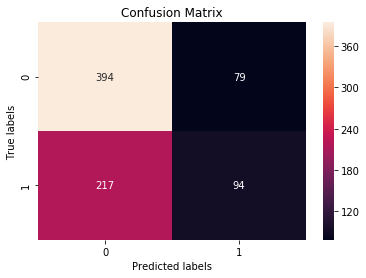

In [20]:
svm_cm = confusion_matrix(y_test, y_pred)
plotCM(svm_cm)